## Задание Pro


Обучите автокодировщик на 10 красивых цифрах 5 из mnist и отредактируйте с помощью него все остальные цифры 5.

Алгоритм действий:
1. Выберите 10 самых красивых по вашем мнению пятерок в тренировочной выборке mnist. 
2. Создайте датасет, где объекты – это все пятерки из тренировочной части mnist, а метки – это случайные пятерки из "красивого" набора. 
3. Создайте автокодировщик и проверьте, совпадают ли у него размеры выхода и входа.
4. Обучите автокодировщик.
5. Добейтесь ошибки MSE на тренировочной выборке **<0.05**. 
6. Посмотрите, как выглядят пятерки из тестовой выборки после обученного автокодировщика.

## Импорт библиотек

In [ ]:
# Для операций с тензорами
import numpy as np

# Для отрисвоки
import matplotlib.pyplot as plt

# Для создания модели
from tensorflow.keras.models import Model

# Необходимые слои
from tensorflow.keras.layers import Input, Conv2DTranspose, MaxPooling2D, Conv2D, BatchNormalization

# Слои для латентного пространства модели
from tensorflow.keras.layers import Flatten, Reshape, Dense

# Оптимизатор
from tensorflow.keras.optimizers import Adam

# Для загрузки базы
from tensorflow.keras.datasets import mnist

## Загрузка данных

In [ ]:
# Загрузка датасета
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 2s 0us/step


In [ ]:
# Нормализация данных
X_train = X_train.astype('float32')/255.
X_test = X_test.astype('float32')/255.

In [ ]:
# Приведение формы к удобной для Keras
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

In [ ]:
# Отбор пятерок
mask = y_train == 5
X_train = X_train[mask]
y_train = y_train[mask]

In [ ]:
# Аналогично для тестирования
mask = y_test == 5
X_test = X_test[mask]
y_test = y_test[mask]

## Отбор красивых пятерок

In [ ]:
# Ваше решение

In [ ]:
# Проверка формы данных
print(X_train.shape)
print(y_train.shape)

(5421, 28, 28, 1)
(5421,)


In [ ]:
# Проверка формы данных
print(X_test.shape)
print(y_test.shape)

(892, 28, 28, 1)
(892,)


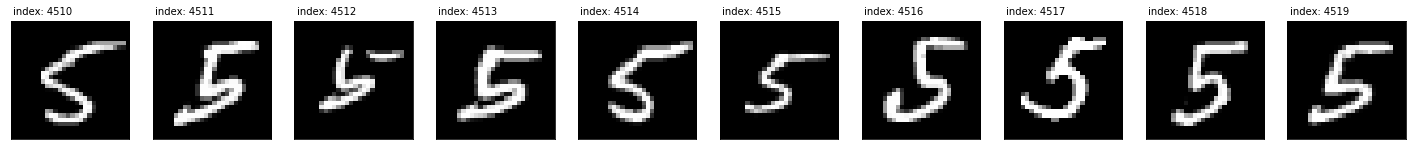

In [ ]:
#Выбор красивых 5 
def show_ten_fives(X, index_to_start=None):

  # Задание размера полотна
  plt.figure(figsize=(25,4))

  # Задание первого индекса для отрисовки. Отрисовка происходит с N по N+10-ю картинку
  if not index_to_start:
    index_to_start = 0

  # Отрисовка каждой из 10 картинок
  for j in range(10):

    # Расположение картинки на полотне
    ax = plt.subplot(1, 10, j+1)

    # Отрисоква картинки
    plt.imshow(X[j+index_to_start].reshape(28,28))

    # Подпись индекса
    ax.text(0, -2, s='index: ' + str(j+index_to_start))

    # Серая гамма
    plt.gray()

    # Стирание осей
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)      

  # Отображение полотна
  plt.show()

show_ten_fives(X_train, index_to_start=4510)

In [ ]:
# Индексы красивых пятерок
nice_indexes = [2,30,65,86,143,192,1212,2214,5214,4515]

# Доставание из тренировочной выборки нужных пятерок
ten_nice_fives = X_train[nice_indexes]


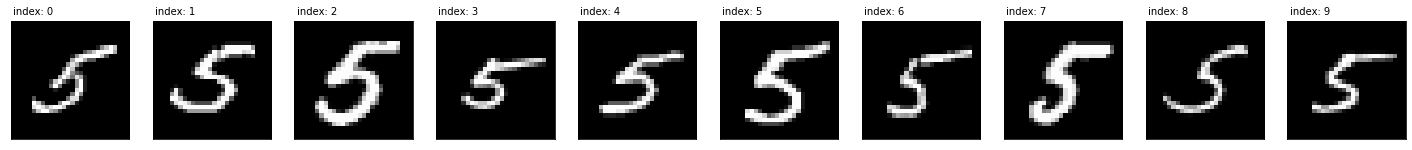

In [ ]:

# Отрисовка пятерок

show_ten_fives(ten_nice_fives)

In [ ]:
# Создание меток путем многократного размножения 10 красивых пятерок
X_train_nice = np.repeat(ten_nice_fives, len(X_train) // len(ten_nice_fives) + 1, axis=0)

# Обрезание лишних меток для совпадения длин вектора меток и тренировочного
X_train_nice = X_train_nice[:len(X_train)]

# Перемешка меток.
np.random.shuffle(X_train_nice)

# Форма тензора меток
X_train_nice.shape

(5421, 28, 28, 1)

In [ ]:
# Функция сборки сверточного автокодировщика
def create_base_ae(in_shape):
    # Энкодер, вход нейросети
    img_input = Input(in_shape)

    # Энкодер, первый блок
    #Состав блока: Двумерная свертка. Нормализация. Двумерная свертка. Нормализация. Снижение размерности.


    # 1.1. Двумерная свертка
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(img_input) 
    # 1.2. Нормализация
    x = BatchNormalization()(x)
    # 1.3. Двумерная свертка
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x) 
    # 1.4. Двумерная свертка
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x) 
    # 1.5. Снижение размерности и обобщение данных
    x = MaxPooling2D()(x)

    # Энкодер, второй блок
    # 2.1. Двумерная свертка
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x) 
    # 2.2. Нормализация
    x = BatchNormalization()(x)
    # 2.3. Двумерная свертка
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    # 2.4. Двумерная свертка
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    
    
    # На выходе кодировщика и на входе декодировщика z - вектор латентного пространства
    # 2.5. Снижение размерности и обобщение данных
    z = MaxPooling2D()(x)
        

    # Декодер, первый блок
    #Состав блока: Повышение размерности. Нормализация. Двумерная свертка. Нормализация Двумерная свертка. Нормализация.


    # 1.1. Транспонированная свертка - повышение размерности данных
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', activation='relu')(z)
    # 1.2. Нормализация
    x = BatchNormalization()(x) 
    # 1.3. Двумерная свертка
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)

    # 1.4. Двумерная свертка
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    # 1.5. Двумерная свертка
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)

    # Декодер, второй блок
    # 2.1. Транспонированная свертка - повышение размерности данных
    x = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same', activation='relu')(x) 
    # 2.2. Нормализация
    x = BatchNormalization()(x) # слой нормализации данных
    # 2.3. Двумерная свертка
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x) 

    # 2.4. Двумерная свертка
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x) 
    # 2.5. Двумерная свертка
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x) 

    # Декодер, финальный слой двумерной свертки, выдающий итоговое изображение
    outputs = Conv2D(in_shape[-1], (3, 3), activation='sigmoid', padding='same')(x)



    #После двух блоков декодера идет финальный слой двумерной свертки декодера, который выдает итоговое изображение. 
    #Прописав структуру автокодировщика, вам остается собрать ее model = Model(inputs, outputs), 
    #в которой на вход подается оригинальное изображение, а на выходе – изображение после сжатия и его восстановления. 
    #Компилируйте сеть, используя оптимизатор Adam и ошибку mse. 
    #Так как модель создана в функции, ее нужно вернуть посредством return model.

    # Сборка модели, на входе оригинальное изображение, на выходе - сжатое-восстановленное
    model = Model(inputs=img_input, outputs=outputs) 

    # Компиляция сети, назначение оптимизатора Adam + среднеквадратическая ошибка
    model.compile(optimizer=Adam(learning_rate=0.00001), loss='mse') 

    # Возврат готовой модели
    return model 

In [ ]:
# Функция последовательного вывода нескольких изображений для сравнения
def plot_images(x_data, pred, n=10): 

    plt.figure(figsize=(14, 7))                     # Размер полотна

    for i in range(1, n + 1):                              # Повтор n раз:
        index = np.random.randint(0, pred.shape[0]) # Выбор случайного индекса 

        # Показ картинки с индексом index из набора x_data
        ax = plt.subplot(2, n, i)               # Картинка располагается в верхнем ряду
        plt.imshow(x_data[index].squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False) 
        ax.get_yaxis().set_visible(False) 

        # Показ картинки с тем же индексом из предсказания автокодировщика
        ax = plt.subplot(2, n, i + n)           # Картинка располагается в нижнем ряду
        plt.imshow(pred[index].squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

In [ ]:
# Проверка формы данных
print(X_train_nice.shape)
print(y_train.shape)

(5421, 28, 28, 1)
(5421,)


In [ ]:
# Сборка автокодировщика для формы картинок датасета
ae_mnist = create_base_ae(X_train_nice.shape[1:])

In [ ]:
# Сводка архитектуры автокодировщика
ae_mnist.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_63 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 batch_normalization_64 (Bat  (None, 28, 28, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_64 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 conv2d_65 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                      

In [ ]:
# Функции-утилиты
from tensorflow.keras import utils

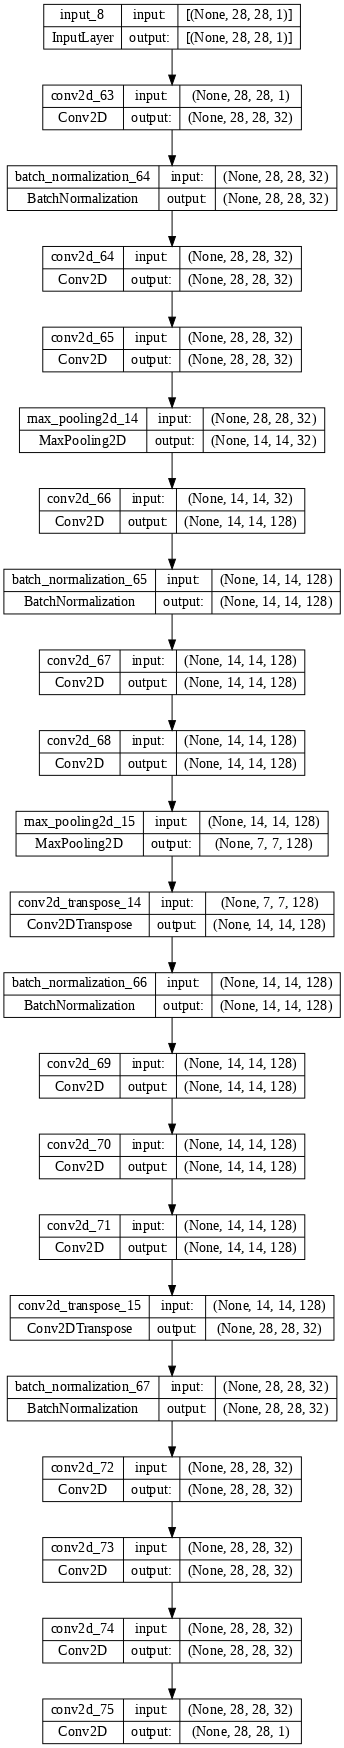

In [ ]:
# Визуальная схема архитектуры модели
utils.plot_model(ae_mnist, 
                 dpi=70,                  # число точек на дюйм (дюйм = 2.54 см)
                 show_shapes=True         # отображение ожидаемых форм входных и выходных тензоров каждого слоя
                 )

In [ ]:
# Обучение модели автокодировщика, на входе и выходе одни и те же данные
history = ae_mnist.fit(X_train, X_train_nice,
                       epochs=50,
                       batch_size=250,
                       shuffle=True,
                       validation_split=0.2
                       )

Epoch 1/50
18/18 [==============================] - 2s 94ms/step - loss: 0.0404 - val_loss: 0.0417
Epoch 2/50
18/18 [==============================] - 2s 90ms/step - loss: 0.0401 - val_loss: 0.0416
Epoch 3/50
18/18 [==============================] - 2s 91ms/step - loss: 0.0399 - val_loss: 0.0413
Epoch 4/50
18/18 [==============================] - 2s 91ms/step - loss: 0.0398 - val_loss: 0.0412
Epoch 5/50
18/18 [==============================] - 2s 91ms/step - loss: 0.0396 - val_loss: 0.0410
Epoch 6/50
18/18 [==============================] - 2s 91ms/step - loss: 0.0394 - val_loss: 0.0408
Epoch 7/50
18/18 [==============================] - 2s 92ms/step - loss: 0.0393 - val_loss: 0.0407
Epoch 8/50
18/18 [==============================] - 2s 94ms/step - loss: 0.0391 - val_loss: 0.0405
Epoch 9/50
18/18 [==============================] - 2s 92ms/step - loss: 0.0390 - val_loss: 0.0403
Epoch 10/50
18/18 [==============================] - 2s 92ms/step - loss: 0.0388 - val_loss: 0.0402
Epoch 11/

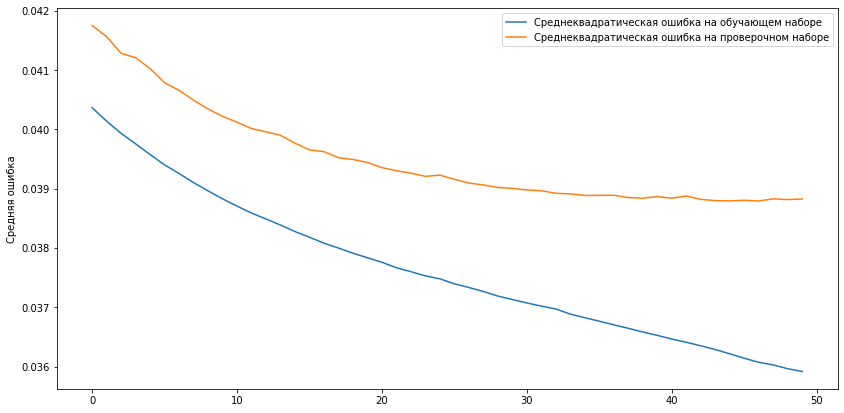

In [ ]:
# Вывод графиков процесса обучения
plt.figure(figsize=(14,7))
plt.plot(history.history['loss'][0:], 
         label='Среднеквадратическая ошибка на обучающем наборе')
plt.plot(history.history['val_loss'][0:], 
         label='Среднеквадратическая ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [ ]:
# Работа с операционной системой
import os

In [ ]:
# путь к папке для хранения моделей
PATH = '/content/my_ae_models'

# создадим папку для моделей, если её еще нет
if not os.path.isdir(PATH):
  os.mkdir(PATH)

In [ ]:
# Сохранение/восстановление параметров модели
ae_mnist.save_weights(PATH + '/ae_mnist.h5') # Сохраняем модель
ae_mnist.load_weights(PATH + '/ae_mnist.h5') # Загружаем модель

In [ ]:
# Получение предсказания автокодировщика на тренировочной и тестовой выборках
pred_train_mnist = ae_mnist.predict(X_train)
pred_test_mnist = ae_mnist.predict(X_test)

28/28 [==============================] - 0s 5ms/step


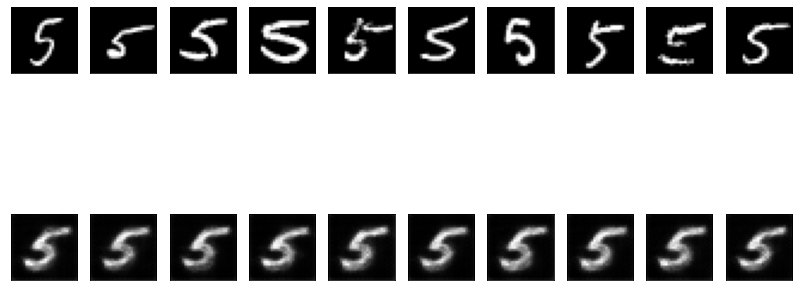

In [ ]:
# Сравнение исходных и восстановленных картинок из тестовой выборки
plot_images(X_test, pred_test_mnist)